# Basic CNN

Some goals in this notebook:
- set up pipeline for training dataset on a basic configuration of CNN. This pipe will be built for subset of 2000 images first (small, balanced dataset), but will later be applied to our real training dataset (also balanced, but with 16k images).
- basic hyperparmater tuning, optimizing for AUC (ROC)


In [ ]:
!pip install optuna
!pip install tensorflow-addons

In [2]:
import joblib

import tensorflow as tf
import tensorflow_addons as tfa
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as sklearn_metrics

import constants
import lesion_data

## Load dataset

Here, I'm using a subbset of training data, which is a balanced dataset of all 8 classes, with 239 images each. I won't be using validation data yet (TBD).

In [4]:
random_seed = 21

train_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_training_augmented_path_with_count_suffix(count=250),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_validation_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

Found 2000 files belonging to 8 classes.
Found 2028 files belonging to 8 classes.


In [5]:
tf.keras.backend.clear_session()
metrics = [
    "accuracy",
    tf.metrics.Precision(name="precision"),
    tf.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
    tf.keras.metrics.AUC(curve="ROC", name="auc_roc"),
    tfa.metrics.F1Score(num_classes=8, name="f1_score"),
]

# For quality of life
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        mark = "*"
        if epoch % 10 == 9:
            mark = "*|"
        print(mark, end="")

def plot_history_df(history_df: pd.DataFrame):
    x_arr = np.arange(len(history_df['loss'])) + 1

    fig = plt.figure(figsize=(18, 9))
    for i, metric in enumerate(["loss", "accuracy", "precision", "recall", "auc_pr", "auc_roc"]):
        ax = fig.add_subplot(2, 3, i+1)
        ax.plot(x_arr, history_df[metric], '-', label=f'Train {metric}')
        ax.plot(x_arr, history_df[f'val_{metric}'], '--', label=f'Validation {metric}')
        ax.legend(fontsize=10)
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel(metric, size=15)

## Building model

The basic CNN model will have the following elements:

1. _**A**_ sets of: (choose 2 to 3 sets -- use `Sequential`)
    1. Conv2D with:
        1. _**B**_ filters (choose between 5 and 24)
        1. _**C**_ kernel size (choose 3 to 5)
        1. _**D**_ setting of padding/no padding (bool)
        1. activation: relu
    1. MaxPooling
        1. _**E**_ pool size (choose between 2 and 3)
        1. _**F**_ stride (choose between 2 and 3)
    1. Dropout - 0.1
1. Flatten
1. _**G**_ layers of Dense (choose between 0 and 3 layers; another `Sequential`)
    1. _**H**_ units (choose 5 to 20)
    1. Activation: relu
    1. Dropout - 0.1
1. One output layer of Dense
    1. output units: 8
    1. Activation: softmax
    
Next, I'll build a model with these parameterizable bits configurable via a function, setting some initial parameter values as defaults, so that we can use them for hyperparameter tuning later.

In [6]:
IMG_SHAPE = (224, 224, 3)

total_conv_layers = 2
number_of_filters = 16
kernel_size = 3
padding_on = True
pool_size = 2
pool_stride = 2

total_dense_layers = 2
dense_units = 10

dropout_rate = 0.2

tf.keras.backend.clear_session()

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.1),
    ],
    name="mini_augmentation",
)

conv_layers = tf.keras.models.Sequential(name="conv_layers")
for conv_layer_num in range(total_conv_layers):
    conv_layers.add(
        tf.keras.layers.Conv2D(
            filters=number_of_filters,
            kernel_size=kernel_size,
            activation="relu",
            padding="same" if padding_on else "valid",
            name=f"Conv2D_{conv_layer_num}",
        )
    )
    conv_layers.add(
        tf.keras.layers.MaxPooling2D(
            pool_size=pool_size,
            strides=pool_stride,
            name=f"MaxPool_{conv_layer_num}",
        )
    )
    conv_layers.add(
        tf.keras.layers.Dropout(dropout_rate, name=f"conv_dropout_{conv_layer_num}")
    )
    conv_layers.add(
        tf.keras.layers.BatchNormalization()
    )

dense_layers = tf.keras.models.Sequential(name="dense_layers")
for dense_layer_num in range(total_dense_layers):
    dense_layers.add(
        tf.keras.layers.Dense(
            dense_units,
            activation="relu",
            name=f"Dense_{dense_layer_num}",
        )
    )
    dense_layers.add(
        tf.keras.layers.Dropout(dropout_rate, name=f"dense_dropout_{dense_layer_num}")
    )
    dense_layers.add(
        tf.keras.layers.BatchNormalization()
    )

# putting it altogether
inputs = tf.keras.Input(shape=IMG_SHAPE)

x = data_augmentation(inputs)
x = conv_layers(x) # Conv layers
x = tf.keras.layers.Flatten()(x)
x = dense_layers(x) # Dense layers

outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

model = tf.keras.Model(inputs, outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mini_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
conv_layers (Sequential)     (None, 56, 56, 16)        2896      
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense_layers (Sequential)    (None, 10)                501960    
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
Total params: 504,944
Trainable params: 504,840
Non-trainable params: 104
_____________________________________________________

In [8]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)

In [ ]:
# Test 20 epoch
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=100,
    batch_size=32,
    callbacks=[CustomCallback()],
    verbose=0,
)

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-12-05 22:48:08.239 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:6523 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-05 22:48:08.427 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:6523 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
**********|**********|**********|**********|**********|**********|**********|******

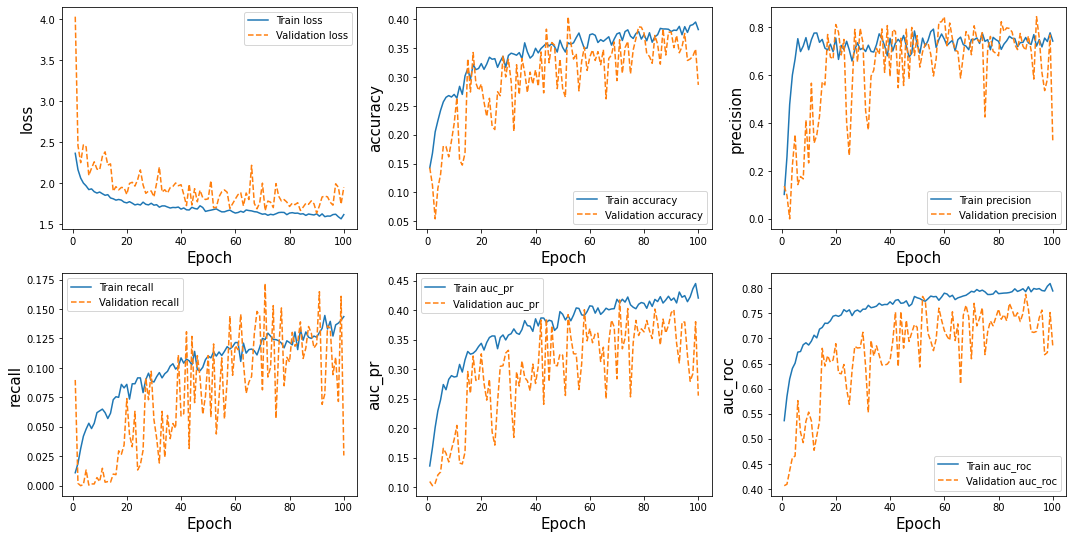

In [14]:
history_df = pd.DataFrame(history.history)
plot_history_df(history_df)

In this initial attempt at basic CNN, the data seems to be not overfitted (great!). Now we move onto hyperparameter tuning.

In [15]:
# Save model
model.save("saved_models/cnn/simple_model_2k.h5")
history_df.to_csv("saved_models/cnn/simple_model_2k_history.csv")

## Using [optuna](https://optuna.org/) for hyperparameter tuning

We will set up the model as something that can be manipulated by optuna, then run say 100 trials to figure out the best hyperparameters on our dataset.

In [43]:
# Parameterize our entire model
verbose=False
IMG_SHAPE = (224, 224, 3)

best_model = None
best_auc = -1

def build_and_compile_model_optuna(trial):
    # Suggest values of the hyperparameters using a trial object.
    dropout_rate = 0.1
    padding_global = trial.suggest_categorical("padding_global", ["same", "valid"])

    conv_layers = tf.keras.models.Sequential(name="conv_layers")
    for conv_layer_num in range(trial.suggest_int("total_conv_layers", 2, 3)):
        conv_layers.add(
            tf.keras.layers.Conv2D(
                filters=trial.suggest_int(f"conv_layer_{conv_layer_num}_number_of_filters", 5, 16),
                kernel_size=trial.suggest_int(f"conv_layer_{conv_layer_num}_kernel_size", 3, 5),
                activation="relu",
                padding=padding_global,
                name=f"Conv2D_{conv_layer_num}",
            )
        )
        conv_layers.add(
            tf.keras.layers.MaxPooling2D(
                pool_size=trial.suggest_int(f"conv_layer_{conv_layer_num}_pool_size", 2, 3),
                strides=trial.suggest_int(f"conv_layer_{conv_layer_num}_strides", 2, 3),
                name=f"MaxPool_{conv_layer_num}",
            )
        )
        conv_layers.add(
            tf.keras.layers.Dropout(dropout_rate, name=f"conv_dropout_{conv_layer_num}")
        )
        conv_layers.add(
            tf.keras.layers.BatchNormalization()
        )

    dense_layers = tf.keras.models.Sequential(name="dense_layers")
    for dense_layer_num in range(trial.suggest_int("total_dense_layers", 0, 3)):
        dense_layers.add(
            tf.keras.layers.Dense(
                trial.suggest_int(f"dense_layer_{dense_layer_num}_dense_units", 5, 20),
                activation="relu",
                name=f"Dense_{dense_layer_num}",
            )
        )
        dense_layers.add(
            tf.keras.layers.Dropout(dropout_rate, name=f"dense_dropout_{dense_layer_num}")
        )
        dense_layers.add(
            tf.keras.layers.BatchNormalization()
        )

    # putting it altogether
    inputs = tf.keras.Input(shape=IMG_SHAPE)

    x = conv_layers(inputs) # Conv layers
    x = tf.keras.layers.Flatten()(x)
    x = dense_layers(x) # Dense layers

    outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer="adam",
        metrics=metrics,
    )

    return model

# Define an objective function to be maximized.
def objective(trial):
    tf.keras.backend.clear_session()
    
    global best_auc
    global best_model
    if verbose:
        print(f"Current {best_auc=}")
    model = build_and_compile_model_optuna(trial)
    random_seed = 21
    callbacks = [
        CustomCallback(),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=20, mode='max'),
    ]
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=int(verbose),
    )
    last_auc = history.history["val_auc_roc"][-1]

    # Additional - if it's best model, save it
    if last_auc > best_auc:
        best_auc = last_auc
        if verbose:
            print(f"New {best_auc=}")
        best_model = model
        best_model.save("saved_models/cnn/best_model_2k.h5")
        history_df = pd.DataFrame(history.history)
        history_df.to_csv("saved_models/cnn/best_model_2k_history.csv")

    return last_auc

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

joblib.dump(study, "saved_models/cnn/best_model_2k_study.pkl")

[I 2022-12-01 07:47:20,255] A new study created in memory with name: no-name-340a1403-6692-48f8-8132-c31ee11861cb


**********|**********|**********|**********|******

[I 2022-12-01 07:51:59,940] Trial 0 finished with value: 0.705884575843811 and parameters: {'padding_global': 'same', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 6}. Best is trial 0 with value: 0.705884575843811.


***********|**********|**********|*******

[I 2022-12-01 07:55:50,341] Trial 1 finished with value: 0.6815080642700195 and parameters: {'padding_global': 'same', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 5, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 12, 'conv_layer_1_kernel_size': 3, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'total_dense_layers': 0}. Best is trial 0 with value: 0.705884575843811.


***********|**********|

[I 2022-12-01 07:57:57,663] Trial 2 finished with value: 0.6813911199569702 and parameters: {'padding_global': 'valid', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 16, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 2, 'total_dense_layers': 3, 'dense_layer_0_dense_units': 5, 'dense_layer_1_dense_units': 16, 'dense_layer_2_dense_units': 8}. Best is trial 0 with value: 0.705884575843811.


***********|**********|**********|**********|**********|**

[I 2022-12-01 08:03:21,954] Trial 3 finished with value: 0.7317966222763062 and parameters: {'padding_global': 'valid', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 8, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 7, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 2, 'conv_layer_2_number_of_filters': 6, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 2, 'conv_layer_2_strides': 2, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 20}. Best is trial 3 with value: 0.7317966222763062.


***********|**********|**********|*

[I 2022-12-01 08:06:32,734] Trial 4 finished with value: 0.6687423586845398 and parameters: {'padding_global': 'valid', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 12, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 5, 'conv_layer_1_kernel_size': 3, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 2, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 10}. Best is trial 3 with value: 0.7317966222763062.


***********|**********|**********|*******

[I 2022-12-01 08:10:27,333] Trial 5 finished with value: 0.7030941247940063 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 9, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 7, 'conv_layer_1_kernel_size': 3, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 5, 'conv_layer_2_kernel_size': 5, 'conv_layer_2_pool_size': 2, 'conv_layer_2_strides': 3, 'total_dense_layers': 3, 'dense_layer_0_dense_units': 13, 'dense_layer_1_dense_units': 12, 'dense_layer_2_dense_units': 20}. Best is trial 3 with value: 0.7317966222763062.


***********|**********|*********

[I 2022-12-01 08:13:30,971] Trial 6 finished with value: 0.607995331287384 and parameters: {'padding_global': 'same', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 8, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 10, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 2, 'total_dense_layers': 0}. Best is trial 3 with value: 0.7317966222763062.


*|**********|**********|**********|*****

[I 2022-12-01 08:17:04,817] Trial 7 finished with value: 0.7032252550125122 and parameters: {'padding_global': 'valid', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 18, 'dense_layer_1_dense_units': 16}. Best is trial 3 with value: 0.7317966222763062.


***********|**********|**********|**********|*********

[I 2022-12-01 08:22:21,242] Trial 8 finished with value: 0.6739165186882019 and parameters: {'padding_global': 'same', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 7, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 13, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 5}. Best is trial 3 with value: 0.7317966222763062.


*|**********|**********|**********|*********

[I 2022-12-01 08:26:20,765] Trial 9 finished with value: 0.6012207269668579 and parameters: {'padding_global': 'valid', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 6, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 6, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 2, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 19, 'dense_layer_1_dense_units': 20}. Best is trial 3 with value: 0.7317966222763062.


*|**********|**********|**********|**

[I 2022-12-01 08:29:41,424] Trial 10 finished with value: 0.64683598279953 and parameters: {'padding_global': 'valid', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 11, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 9, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 2, 'conv_layer_2_number_of_filters': 8, 'conv_layer_2_kernel_size': 3, 'conv_layer_2_pool_size': 2, 'conv_layer_2_strides': 2, 'total_dense_layers': 0}. Best is trial 3 with value: 0.7317966222763062.


***********|**********|**********|**********|**********|**********|**********|**********|********

[I 2022-12-01 08:38:33,429] Trial 11 finished with value: 0.7929583787918091 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 14}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|**

[I 2022-12-01 08:42:55,404] Trial 12 finished with value: 0.7415230870246887 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 12, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 8, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 2, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 15}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|*

[I 2022-12-01 08:47:08,363] Trial 13 finished with value: 0.7439417839050293 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 9, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 15, 'dense_layer_1_dense_units': 5}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|**********|*****

[I 2022-12-01 08:52:47,534] Trial 14 finished with value: 0.7738037705421448 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 11, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 15, 'dense_layer_1_dense_units': 5}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|***

[I 2022-12-01 08:57:15,031] Trial 15 finished with value: 0.7421383261680603 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 3, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 10, 'dense_layer_1_dense_units': 5}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|********

[I 2022-12-01 09:02:16,932] Trial 16 finished with value: 0.7137923240661621 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 11, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 12, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 12, 'conv_layer_2_kernel_size': 5, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 3, 'dense_layer_0_dense_units': 16, 'dense_layer_1_dense_units': 9, 'dense_layer_2_dense_units': 17}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|**********|**********|********

[I 2022-12-01 09:09:15,637] Trial 17 finished with value: 0.7599117159843445 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 11, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 12, 'dense_layer_1_dense_units': 9}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|**********|**********|**********|**

[I 2022-12-01 09:16:34,803] Trial 18 finished with value: 0.7623634934425354 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 10, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 3, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 17}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|********

[I 2022-12-01 09:19:28,580] Trial 19 finished with value: 0.6432380080223083 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 13, 'conv_layer_1_kernel_size': 3, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 10, 'conv_layer_2_kernel_size': 5, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 13, 'dense_layer_1_dense_units': 9}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|**********|*********

[I 2022-12-01 09:25:31,678] Trial 20 finished with value: 0.7255682349205017 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 16, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 10, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 0}. Best is trial 11 with value: 0.7929583787918091.


*|**********|**********|**********|**********|*

[I 2022-12-01 09:29:48,881] Trial 21 finished with value: 0.7472981810569763 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 10, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 12, 'conv_layer_2_kernel_size': 3, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 17}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|**********|

[I 2022-12-01 09:34:55,503] Trial 22 finished with value: 0.7673218250274658 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 10, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 3, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 15}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|**********|

[I 2022-12-01 09:40:00,864] Trial 23 finished with value: 0.7403128743171692 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 12, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 3, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 14}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|**********|**********|*******

[I 2022-12-01 09:46:49,225] Trial 24 finished with value: 0.7599170207977295 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 9, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 3, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 10, 'dense_layer_1_dense_units': 12}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|*******

[I 2022-12-01 09:50:38,729] Trial 25 finished with value: 0.7233573198318481 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 5, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|******

[I 2022-12-01 09:55:19,982] Trial 26 finished with value: 0.7373837232589722 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 12, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 2, 'conv_layer_2_strides': 2, 'total_dense_layers': 0}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|*

[I 2022-12-01 09:57:34,132] Trial 27 finished with value: 0.624262809753418 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 11, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 13, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 11, 'conv_layer_2_kernel_size': 3, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 15, 'dense_layer_1_dense_units': 7}. Best is trial 11 with value: 0.7929583787918091.


***********|**********|**********|**********|**********|**********|*********

[I 2022-12-01 10:04:42,240] Trial 28 finished with value: 0.7605427503585815 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 12, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 2, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 11, 'conv_layer_1_kernel_size': 4, 'conv_layer_1_pool_size': 2, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 3, 'dense_layer_0_dense_units': 11, 'dense_layer_1_dense_units': 14, 'dense_layer_2_dense_units': 5}. Best is trial 11 with value: 0.7929583787918091.


*|**********|**********|**********|**********|*

[I 2022-12-01 10:08:57,446] Trial 29 finished with value: 0.8099827766418457 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 14}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|**********|********

[I 2022-12-01 10:14:49,911] Trial 30 finished with value: 0.7277490496635437 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 9, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 2, 'conv_layer_2_strides': 2, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 7, 'dense_layer_1_dense_units': 18}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|*********

[I 2022-12-01 10:19:51,820] Trial 31 finished with value: 0.7392141222953796 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 14}. Best is trial 29 with value: 0.8099827766418457.


*|**********|**********|**********|*********

[I 2022-12-01 10:23:53,663] Trial 32 finished with value: 0.7744734287261963 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 16}. Best is trial 29 with value: 0.8099827766418457.


*|**********|**********|**********|**********|**********|*

[I 2022-12-01 10:29:11,471] Trial 33 finished with value: 0.7270829677581787 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 16, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 0}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|******

[I 2022-12-01 10:33:53,197] Trial 34 finished with value: 0.7641509771347046 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 17}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|**********|*******

[I 2022-12-01 10:39:43,241] Trial 35 finished with value: 0.7533082962036133 and parameters: {'padding_global': 'valid', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 16}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|*********

[I 2022-12-01 10:43:45,799] Trial 36 finished with value: 0.7676458954811096 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 16, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 14}. Best is trial 29 with value: 0.8099827766418457.


*|**********|**********|**********|**********|**********|**********|**********|*******

[I 2022-12-01 10:51:35,203] Trial 37 finished with value: 0.7443446516990662 and parameters: {'padding_global': 'valid', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 12, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 5, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 0}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|*

[I 2022-12-01 10:54:49,817] Trial 38 finished with value: 0.7558761835098267 and parameters: {'padding_global': 'same', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 2, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 16}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|**********|*

[I 2022-12-01 11:00:01,844] Trial 39 finished with value: 0.7512320876121521 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 16, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 7, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 2, 'conv_layer_2_strides': 2, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 8}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|********

[I 2022-12-01 11:03:55,468] Trial 40 finished with value: 0.640064537525177 and parameters: {'padding_global': 'valid', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 13, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 18, 'dense_layer_1_dense_units': 7}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|*******

[I 2022-12-01 11:08:44,453] Trial 41 finished with value: 0.761817991733551 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 16, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 14}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|*********

[I 2022-12-01 11:13:41,304] Trial 42 finished with value: 0.7238713502883911 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 5, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 29 with value: 0.8099827766418457.


*|**********|**********|**********|**********|

[I 2022-12-01 11:17:44,869] Trial 43 finished with value: 0.7877392768859863 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 16, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 14}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|**********|*********

[I 2022-12-01 11:23:40,550] Trial 44 finished with value: 0.8085469007492065 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 29 with value: 0.8099827766418457.


*|**********|**********|**********|**********|**********|*****

[I 2022-12-01 11:29:13,413] Trial 45 finished with value: 0.7649770975112915 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 16, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 5, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 11}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|**********|***

[I 2022-12-01 11:34:34,142] Trial 46 finished with value: 0.7420772910118103 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 2, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 0}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|*******

[I 2022-12-01 11:39:22,028] Trial 47 finished with value: 0.7156140208244324 and parameters: {'padding_global': 'valid', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 5, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 2, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|****

[I 2022-12-01 11:43:48,840] Trial 48 finished with value: 0.737630307674408 and parameters: {'padding_global': 'same', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 13, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 11}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|**********|*****

[I 2022-12-01 11:49:26,150] Trial 49 finished with value: 0.7907002568244934 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|**

[I 2022-12-01 11:53:41,148] Trial 50 finished with value: 0.7333234548568726 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 2, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 5, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 0}. Best is trial 29 with value: 0.8099827766418457.


***********|**********|**********|**********|**********|**********|**********|**********|

[I 2022-12-01 12:01:44,451] Trial 51 finished with value: 0.8157547116279602 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|**********|*********

[I 2022-12-01 12:06:48,147] Trial 52 finished with value: 0.7718385457992554 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 16, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 51 with value: 0.8157547116279602.


*|**********|**********|**********|**********|**********|****

[I 2022-12-01 12:12:23,984] Trial 53 finished with value: 0.8152905702590942 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|

[I 2022-12-01 12:15:29,145] Trial 54 finished with value: 0.7725672721862793 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 9}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|**********|**********|********

[I 2022-12-01 12:21:18,427] Trial 55 finished with value: 0.8091210722923279 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 12, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|**********|**********|********

[I 2022-12-01 12:27:11,150] Trial 56 finished with value: 0.7709847092628479 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 12, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|*********

[I 2022-12-01 12:31:12,069] Trial 57 finished with value: 0.7662523984909058 and parameters: {'padding_global': 'valid', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 12, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 13, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 11, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 11}. Best is trial 51 with value: 0.8157547116279602.


*|**********|**********|**********|**********|

[I 2022-12-01 12:35:22,633] Trial 58 finished with value: 0.8030948042869568 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|*********

[I 2022-12-01 12:38:22,308] Trial 59 finished with value: 0.7777095437049866 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 7, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 12, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 9}. Best is trial 51 with value: 0.8157547116279602.


*|**********|**********|**********|**********|****

[I 2022-12-01 12:42:50,988] Trial 60 finished with value: 0.7691888213157654 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 12, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 5, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 0}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|**********|********

[I 2022-12-01 12:47:47,837] Trial 61 finished with value: 0.7854928970336914 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|**********|****

[I 2022-12-01 12:52:18,741] Trial 62 finished with value: 0.7678617835044861 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 11, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|**********|**********|***

[I 2022-12-01 12:57:37,792] Trial 63 finished with value: 0.7490085363388062 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 12, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 11}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|**********|

[I 2022-12-01 13:01:45,169] Trial 64 finished with value: 0.7344782948493958 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 13, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|**********|*******

[I 2022-12-01 13:06:29,540] Trial 65 finished with value: 0.7847113609313965 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 8, 'conv_layer_1_kernel_size': 3, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 12, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|**********|

[I 2022-12-01 13:10:38,654] Trial 66 finished with value: 0.6880446672439575 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 13, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 10, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 10}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|*******

[I 2022-12-01 13:14:24,858] Trial 67 finished with value: 0.7668272256851196 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 12, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 14, 'dense_layer_1_dense_units': 20}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**

[I 2022-12-01 13:16:42,276] Trial 68 finished with value: 0.7672454118728638 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 11, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 3, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|*

[I 2022-12-01 13:19:52,790] Trial 69 finished with value: 0.7617525458335876 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 4, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 10}. Best is trial 51 with value: 0.8157547116279602.


***********|**********|**********|**********|*********

[I 2022-12-01 13:24:53,242] Trial 70 finished with value: 0.820286214351654 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 6, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 15}. Best is trial 70 with value: 0.820286214351654.


*|**********|**********|**********|**********|***

[I 2022-12-01 13:29:13,935] Trial 71 finished with value: 0.7926465272903442 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 14, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 15}. Best is trial 70 with value: 0.820286214351654.


***********|**********|**********|**********|**********|**********|******

[I 2022-12-01 13:35:57,518] Trial 72 finished with value: 0.8342893123626709 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 8, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|**********|**********|**********|**********|*********

[I 2022-12-01 13:45:53,619] Trial 73 finished with value: 0.7802445292472839 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 7, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 72 with value: 0.8342893123626709.


*|**********|**********|*******

[I 2022-12-01 13:48:40,432] Trial 74 finished with value: 0.6979305148124695 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 8, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 15}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|**********|**********|*********

[I 2022-12-01 13:56:34,173] Trial 75 finished with value: 0.773303747177124 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 6, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 13, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 72 with value: 0.8342893123626709.


*|**********|**********|**********|***

[I 2022-12-01 13:59:56,273] Trial 76 finished with value: 0.7384217381477356 and parameters: {'padding_global': 'valid', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 9, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 12, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**

[I 2022-12-01 14:04:15,041] Trial 77 finished with value: 0.746364414691925 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 6, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 11}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|******

[I 2022-12-01 14:07:53,543] Trial 78 finished with value: 0.781569242477417 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 7, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 20}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|**********|**********|**

[I 2022-12-01 14:15:05,027] Trial 79 finished with value: 0.8281750679016113 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 5, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 14, 'dense_layer_1_dense_units': 14}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|******

[I 2022-12-01 14:19:47,323] Trial 80 finished with value: 0.7879297137260437 and parameters: {'padding_global': 'same', 'total_conv_layers': 2, 'conv_layer_0_number_of_filters': 5, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 14, 'dense_layer_1_dense_units': 14}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|**********|******

[I 2022-12-01 14:26:25,330] Trial 81 finished with value: 0.8014742732048035 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 6, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 3, 'dense_layer_0_dense_units': 15, 'dense_layer_1_dense_units': 17, 'dense_layer_2_dense_units': 13}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|**********|**********|***

[I 2022-12-01 14:33:43,973] Trial 82 finished with value: 0.7872233390808105 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 5, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 12, 'dense_layer_1_dense_units': 14}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|**********|**********|**********|

[I 2022-12-01 14:41:47,523] Trial 83 finished with value: 0.7444829344749451 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 7, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 14, 'dense_layer_1_dense_units': 11}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|******

[I 2022-12-01 14:47:24,436] Trial 84 finished with value: 0.8027545809745789 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 8, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|**********|**********|**********|**********|*

[I 2022-12-01 14:56:30,599] Trial 85 finished with value: 0.7484404444694519 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 5, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 5, 'dense_layer_1_dense_units': 18}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|********

[I 2022-12-01 15:01:26,306] Trial 86 finished with value: 0.7536448836326599 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 6, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 2, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 14}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|***

[I 2022-12-01 15:03:50,213] Trial 87 finished with value: 0.7676663994789124 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 10, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|**********|

[I 2022-12-01 15:09:49,824] Trial 88 finished with value: 0.7816146612167358 and parameters: {'padding_global': 'valid', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 5, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 16}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|*******

[I 2022-12-01 15:13:35,413] Trial 89 finished with value: 0.7531092166900635 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 15}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|********

[I 2022-12-01 15:17:27,900] Trial 90 finished with value: 0.7799158692359924 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 9, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 12, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 2, 'dense_layer_0_dense_units': 11, 'dense_layer_1_dense_units': 11}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|***

[I 2022-12-01 15:22:51,640] Trial 91 finished with value: 0.7188649773597717 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 8, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|*****

[I 2022-12-01 15:25:27,020] Trial 92 finished with value: 0.73350989818573 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 6, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|**********|**********|*******

[I 2022-12-01 15:33:20,930] Trial 93 finished with value: 0.7890371084213257 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 8, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 14}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**********|**********|**********|**********|

[I 2022-12-01 15:41:26,581] Trial 94 finished with value: 0.7960234880447388 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 7, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 3, 'dense_layer_0_dense_units': 13, 'dense_layer_1_dense_units': 15, 'dense_layer_2_dense_units': 12}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|*******

[I 2022-12-01 15:44:14,889] Trial 95 finished with value: 0.7811505794525146 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 13, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 12}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|*********

[I 2022-12-01 15:49:14,025] Trial 96 finished with value: 0.7844005227088928 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 9, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 16, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 14}. Best is trial 72 with value: 0.8342893123626709.


*|**********|**********|**********|**********|*****

[I 2022-12-01 15:53:53,678] Trial 97 finished with value: 0.7477016448974609 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 10, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 10, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 2, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 0}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|**

[I 2022-12-01 15:58:13,849] Trial 98 finished with value: 0.7647658586502075 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 16, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 16, 'conv_layer_1_kernel_size': 3, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 14, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 11}. Best is trial 72 with value: 0.8342893123626709.


***********|**********|**********|**********|*

[I 2022-12-01 16:02:23,874] Trial 99 finished with value: 0.7192662954330444 and parameters: {'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 15, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}. Best is trial 72 with value: 0.8342893123626709.


*

['saved_models/cnn/best_model_2k_study.pkl']

## Post-train evaluation on saved model and study

Look at size of model

In [44]:
!ls saved_models/cnn -lah | grep best_model_2k.h5

-rw-r--r-- 1 root root 286K Dec  1 13:35 best_model_2k.h5


Look at "best_model" history

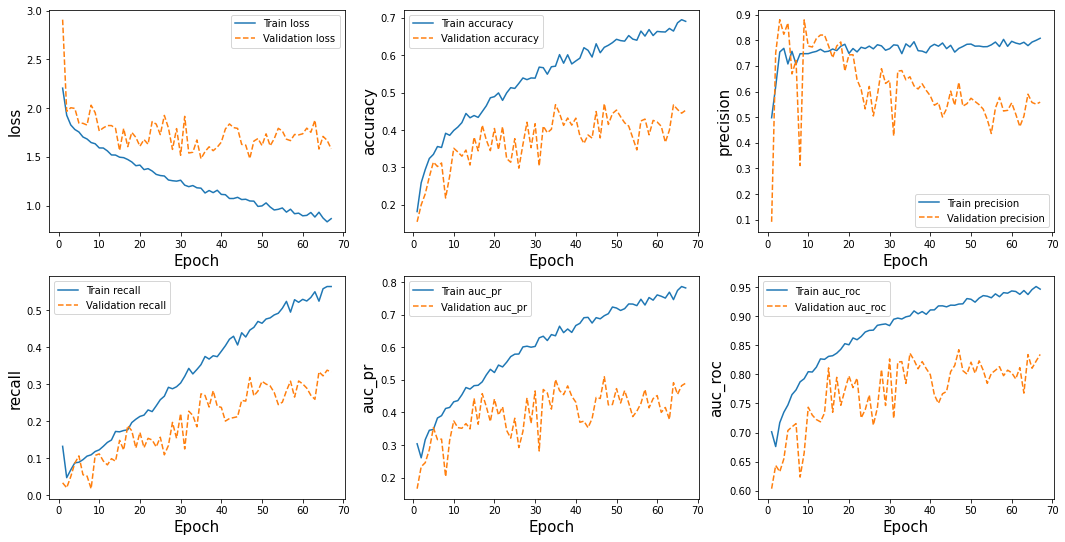

In [45]:
hist = pd.read_csv("saved_models/cnn/best_model_2k_history.csv")
plot_history_df(hist)

Thoughts: noise in validation data might be reduced with a bigger validation dataset (when we look at more than 2000 images).

Look at saved "best_model"

In [4]:
best_model = tf.keras.models.load_model("saved_models/cnn/best_model_2k.h5")

In [46]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_layers (Sequential)     (None, 8, 8, 13)          6516      
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dense_layers (Sequential)    (None, 13)                10881     
_________________________________________________________________
dense (Dense)                (None, 8)                 112       
Total params: 17,509
Trainable params: 17,411
Non-trainable params: 98
_________________________________________________________________


In [47]:
best_model.layers[1].summary()

Model: "conv_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_0 (Conv2D)            (None, 224, 224, 8)       224       
_________________________________________________________________
MaxPool_0 (MaxPooling2D)     (None, 74, 74, 8)         0         
_________________________________________________________________
conv_dropout_0 (Dropout)     (None, 74, 74, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 8)         32        
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 74, 74, 15)        3015      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 24, 24, 15)        0         
_________________________________________________________________
conv_dropout_1 (Dropout)     (None, 24, 24, 15)        

In [48]:
best_model.layers[3].summary()

Model: "dense_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 13)                10829     
_________________________________________________________________
dense_dropout_0 (Dropout)    (None, 13)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 13)                52        
Total params: 10,881
Trainable params: 10,855
Non-trainable params: 26
_________________________________________________________________


Thoughts: it's a very small model! Very few parameters due to huge reduction in output shape from triple MaxPooling with big strides. Surprising that it works well even after that.

Let's look at what each Conv layer is learning (caveat, it's only epoch of 24).

In [49]:
model = best_model.layers[1]
model.layers[0].output

<KerasTensor: shape=(None, 224, 224, 8) dtype=float32 (created by layer 'Conv2D_0')>

In [50]:
one_batch_ds = validation_ds.take(1).as_numpy_iterator()
one_batch = next(one_batch_ds)
one_image, one_image_label = one_batch[0], one_batch[1]

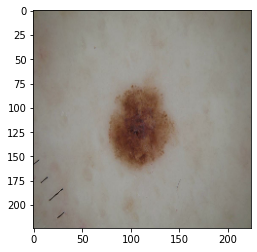

In [51]:
plt.imshow(one_image[0].astype(int))

----------------
Geeting activations of layer 1 : Conv2D_0
Images size is 224 x 224
Number of channels is 8
Printing channels:


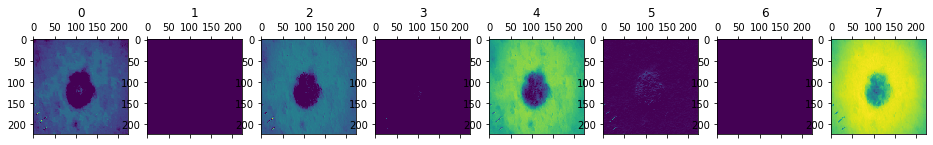

----------------
Geeting activations of layer 2 : MaxPool_0
Images size is 74 x 74
Number of channels is 8
Printing channels:


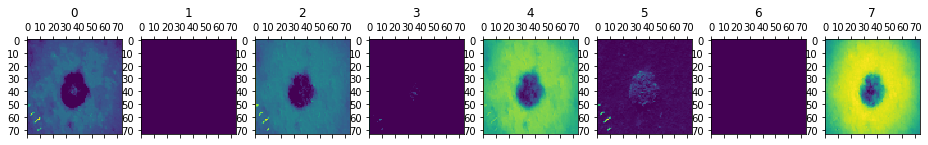

skipping conv_dropout_0
skipping batch_normalization
----------------
Geeting activations of layer 5 : Conv2D_1
Images size is 74 x 74
Number of channels is 15
Printing channels:


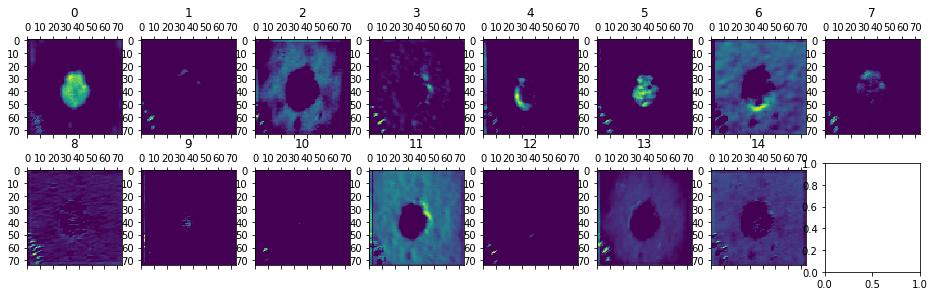

----------------
Geeting activations of layer 6 : MaxPool_1
Images size is 24 x 24
Number of channels is 15
Printing channels:


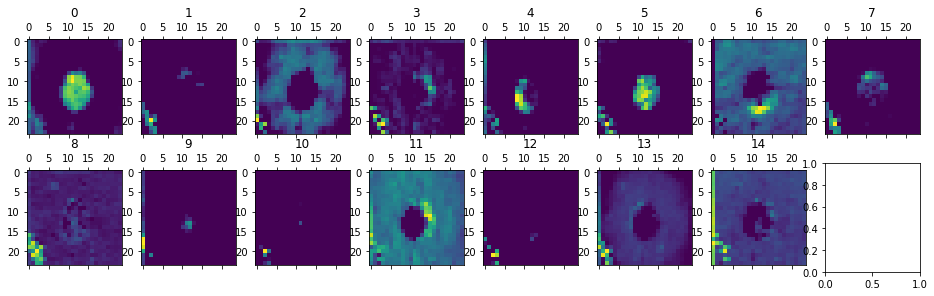

skipping conv_dropout_1
skipping batch_normalization_1
----------------
Geeting activations of layer 9 : Conv2D_2
Images size is 24 x 24
Number of channels is 13
Printing channels:


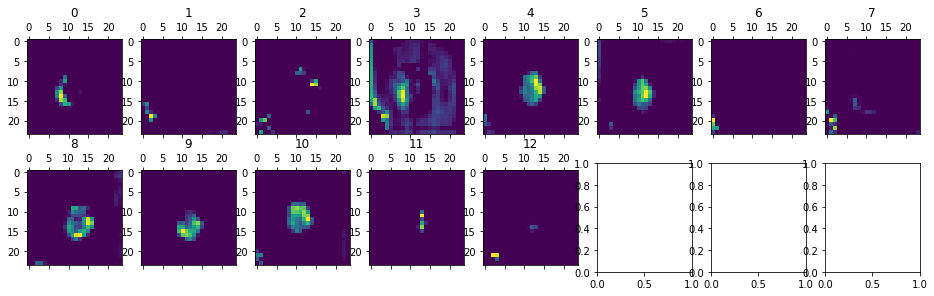

----------------
Geeting activations of layer 10 : MaxPool_2
Images size is 8 x 8
Number of channels is 13
Printing channels:


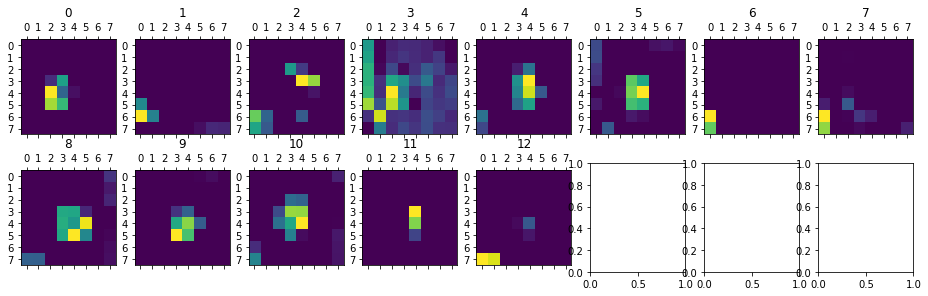

skipping conv_dropout_2
skipping batch_normalization_2


In [59]:
# outputs of layers that are conv2D and max pooling layers
model = best_model.layers[1]
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(one_image)

# vis to skip
models_to_skip = ["dropout", "batch_normalization"]
plots_per_row = 8

# grab layer names
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

# getting activations of each layer
for idx, layer in enumerate(activations):
    skip = False
    for keyword in models_to_skip:
        if keyword in layer_names[idx]:
            print(f"skipping {model.layers[idx].name}")
            skip = True  # skip plotting

    if skip:
        continue

    print('----------------')
    print('Geeting activations of layer',  idx+1, ':', layer_names[idx])
    activation = layer

    # shape of layer activation
    print('Images size is', activation.shape[1], 'x', activation.shape[2])
    print('Number of channels is', activation.shape[3])

    # print channels
    print('Printing channels:')

    number_of_channels = activation.shape[-1]
    # define nrows and ncols depending on number of channels
    nrows, ncols = int(np.ceil(number_of_channels / plots_per_row)), plots_per_row

    # plots
    channel=0
    f, axs = plt.subplots(nrows, ncols, figsize=(plots_per_row * 2, nrows * 2.2))
    if nrows == 1:
        axs = np.array([axs])

    for channel in range(number_of_channels):
        i, j = int(np.floor(channel / plots_per_row)), int(channel % plots_per_row)
        axs[i,j].matshow(activation[0, :, :, channel], cmap ='viridis')
        axs[i,j].set(title=str(channel))
        #axs[i,j].axis('off') # pay attention to the range of x and y axis
    
    plt.show()

Analyze what optuna learned.

In [60]:
loaded_study = joblib.load("saved_models/cnn/best_model_2k_study.pkl")

In [61]:
loaded_study.best_trial

FrozenTrial(number=72, values=[0.8342893123626709], datetime_start=datetime.datetime(2022, 12, 1, 13, 29, 13, 936379), datetime_complete=datetime.datetime(2022, 12, 1, 13, 35, 57, 517875), params={'padding_global': 'same', 'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 8, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 15, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 13, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 13}, distributions={'padding_global': CategoricalDistribution(choices=('same', 'valid')), 'total_conv_layers': IntDistribution(high=3, log=False, low=2, step=1), 'conv_layer_0_number_of_filters': IntDistribution(high=16, log=False, low=5, step=1), 'conv_layer_0_kernel_size': IntDistribution(high=5, log=False, low=3, step=1)

In [62]:
loaded_study.best_trial.params

{'padding_global': 'same',
 'total_conv_layers': 3,
 'conv_layer_0_number_of_filters': 8,
 'conv_layer_0_kernel_size': 3,
 'conv_layer_0_pool_size': 3,
 'conv_layer_0_strides': 3,
 'conv_layer_1_number_of_filters': 15,
 'conv_layer_1_kernel_size': 5,
 'conv_layer_1_pool_size': 3,
 'conv_layer_1_strides': 3,
 'conv_layer_2_number_of_filters': 13,
 'conv_layer_2_kernel_size': 4,
 'conv_layer_2_pool_size': 3,
 'conv_layer_2_strides': 3,
 'total_dense_layers': 1,
 'dense_layer_0_dense_units': 13}

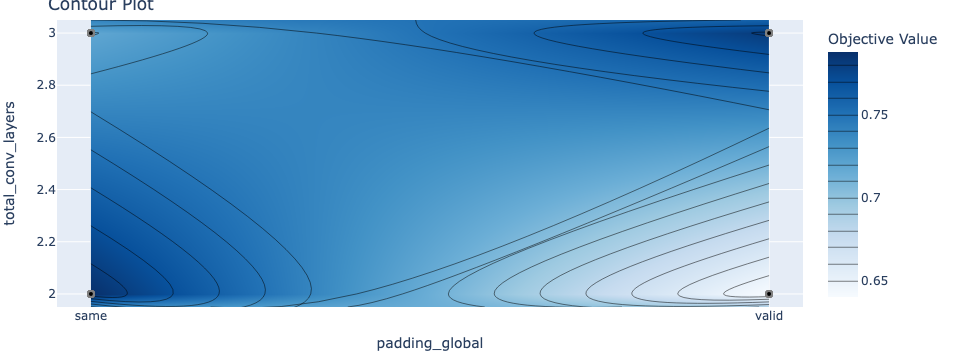

In [72]:
fig = optuna.visualization.plot_contour(
    loaded_study,
    params=[
        'padding_global',
        'total_conv_layers',
        # 'conv_layer_0_number_of_filters',
        # 'conv_layer_0_kernel_size',
        # 'conv_layer_0_pool_size',
        # 'conv_layer_0_strides',
        # 'conv_layer_1_number_of_filters',
        # 'conv_layer_1_kernel_size',
        # 'conv_layer_1_pool_size',
        # 'conv_layer_1_strides',
        # 'conv_layer_2_number_of_filters',
        # 'conv_layer_2_kernel_size',
        # 'conv_layer_2_pool_size',
        # 'conv_layer_2_strides',
        # 'total_dense_layers',
        # 'dense_layer_0_dense_units',
        # 'dense_layer_1_dense_units',
    ],
)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
)

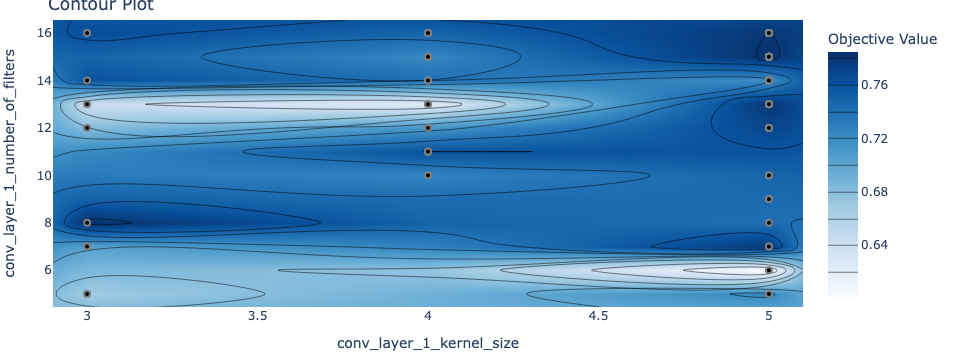

In [82]:
fig = optuna.visualization.plot_contour(
    loaded_study,
    params=[
        # 'padding_global',
        # 'total_conv_layers',
        # 'conv_layer_0_number_of_filters',
        # 'conv_layer_0_kernel_size',
        # 'conv_layer_0_pool_size',
        # 'conv_layer_0_strides',
        'conv_layer_1_number_of_filters',
        'conv_layer_1_kernel_size',
        # 'conv_layer_1_pool_size',
        # 'conv_layer_1_strides',
        # 'conv_layer_2_number_of_filters',
        # 'conv_layer_2_kernel_size',
        # 'conv_layer_2_pool_size',
        # 'conv_layer_2_strides',
        # 'total_dense_layers',
        # 'dense_layer_0_dense_units',
        # 'dense_layer_1_dense_units',
    ],
)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
)

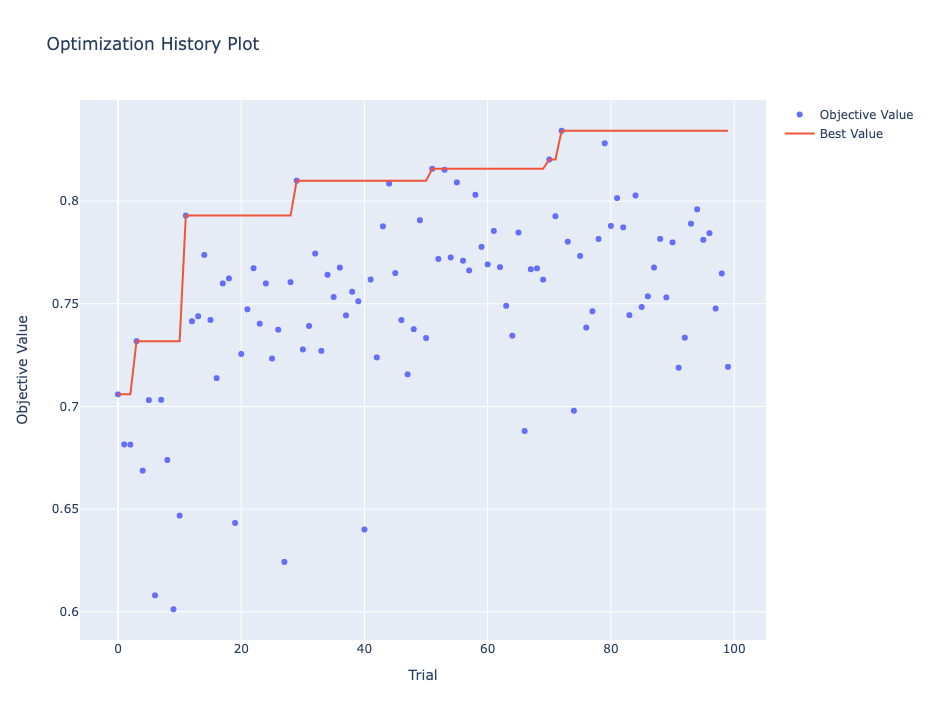

In [75]:
fig = optuna.visualization.plot_optimization_history(loaded_study)
display(fig)

In [ ]:
fig = optuna.visualization.plot_optimization_history(loaded_study)
display(fig)

## Evaluation on test data

First test simple CNN.

In [16]:
random_seed = 21
test_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_testing_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

# Load model from saved file
best_model = tf.keras.models.load_model("saved_models/cnn/simple_model_2k.h5")

best_model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=[
        tf.keras.metrics.Accuracy(name="accuracy"),
        tf.keras.metrics.CategoricalAccuracy(name="accuracy_categorical"),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
        tf.keras.metrics.AUC(curve="ROC", name="auc_roc"),
        tfa.metrics.F1Score(num_classes=8, name="f1_score"),
    ],
)

results = best_model.evaluate(test_ds)

for n, v in zip(best_model.metrics_names, results):
    try:
        print(f"{n}\t: {v:.3f}")
    except:
        print(f"{n}\t: {v}")

Found 5066 files belonging to 8 classes.
159/159 [==============================] - 8s 44ms/step - loss: 1.9494 - accuracy: 0.0000e+00 - accuracy_categorical: 0.2967 - precision: 0.3236 - recall: 0.0284 - auc_pr: 0.2610 - auc_roc: 0.6879 - f1_score: 0.1500
loss	: 1.949
accuracy	: 0.000
accuracy_categorical	: 0.297
precision	: 0.324
recall	: 0.028
auc_pr	: 0.261
auc_roc	: 0.688
f1_score	: [0.03267974 0.38058746 0.04938272 0.         0.18844697 0.45351475
 0.02105263 0.07407407]


In [17]:
test_preds = best_model.predict(test_ds)
test_preds_sparse = np.argmax(test_preds, axis=1)

labels_iterator=test_ds.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels_dense = np.array(list(labels_iterator))
labels_sparse = np.argmax(labels_dense, axis=1)

labels=["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
labels_sorted = sorted(labels)

# Rearrange
sorted_to_real_idx = {labels_sorted.index(l): labels.index(l) for l in labels_sorted}
sorted_to_real_fn = lambda y_sorted: np.array([sorted_to_real_idx[i] for i in y_sorted])
y_true = sorted_to_real_fn(labels_sparse)
y_pred = sorted_to_real_fn(test_preds_sparse)

Classification Report
              precision    recall  f1-score   support

         MEL      0.187     0.254     0.215       895
          NV      0.513     0.185     0.272      2592
         BCC      0.133     0.325     0.189       684
          AK      0.007     0.006     0.007       160
         BKL      0.137     0.040     0.062       502
          DF      0.000     0.000     0.000        44
        VASC      0.006     0.106     0.011        47
         SCC      0.000     0.000     0.000       142

    accuracy                          0.189      5066
   macro avg      0.123     0.114     0.094      5066
weighted avg      0.327     0.189     0.209      5066

Accuracy: 0.1885
ROC AUC: 0.4760


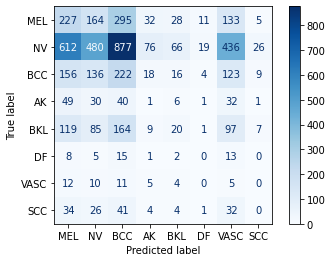

In [18]:
print ("Classification Report")
print(sklearn_metrics.classification_report(y_true, y_pred, labels=range(8), target_names=labels, digits=3))
print(f"Accuracy: {sklearn_metrics.accuracy_score(y_true, y_pred):.4f}")
#'ovr' Stands for One-vs-rest. Computes the AUC of each class against the rest
print(f"ROC AUC: {sklearn_metrics.roc_auc_score(labels_dense, test_preds, multi_class='ovr'):.4f}")

cm = sklearn_metrics.confusion_matrix(y_true, y_pred)
disp = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

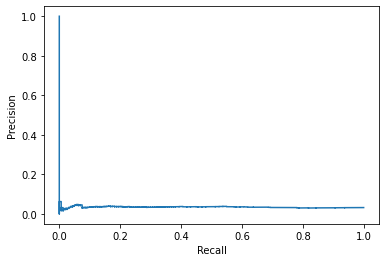

In [116]:
# print(f": {sklearn_metrics.precision_recall_fscore_support(y_true, y_pred, average='macro'):.4f}")

# sklearn_metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')

for idx in range(8):
    pr_curve = sklearn_metrics.precision_recall_curve(labels_dense[:, idx], test_preds[:, idx])
    disp = sklearn_metrics.PrecisionRecallDisplay(pr_curve[0], pr_curve[1])
    disp.plot()
    break

plt.show()

Finally, evaluating the best model identified by Optuna. Note that this is not reported in our presentation or report (we instead present the results in model_cnn_16k, which is trained with larger dataset).

In [ ]:
random_seed = 21
test_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_testing_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

# Load model from saved file
best_model = tf.keras.models.load_model("saved_models/cnn/best_model_2k.h5")

best_model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)

In [24]:
results = best_model.evaluate(test_ds)

for n, v in zip(best_model.metrics_names, results):
    try:
        print(f"{n}\t: {v:.3f}")
    except:
        print(f"{n}\t: {v}")

159/159 [==============================] - 8s 42ms/step - loss: 1.5844 - accuracy: 0.4491 - precision: 0.5541 - recall: 0.3354 - auc_pr: 0.4805 - auc_roc: 0.8351 - f1_score: 0.3216
loss	: 1.584
accuracy	: 0.449
precision	: 0.554
recall	: 0.335
auc_pr	: 0.481
auc_roc	: 0.835
f1_score	: [0.20224719 0.4164794  0.27       0.15325671 0.36042783 0.6360812
 0.19733334 0.33720928]


In [29]:
test_preds = best_model.predict(test_ds)
test_preds_sparse = np.argmax(test_preds, axis=1)

labels_iterator=test_ds.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))
labels_sparse = np.argmax(labels, axis=1)

cm = tf.math.confusion_matrix(
    labels_sparse,
    test_preds_sparse,
    num_classes=8,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

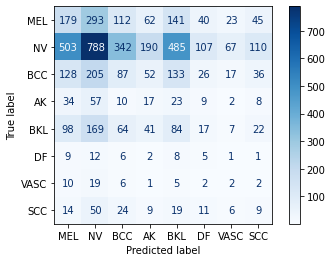

In [31]:
#Confusion matrix: 
labels=["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
labels_sorted = sorted(labels)

# Rearrange
sorted_to_real_idx = {labels_sorted.index(l): labels.index(l) for l in labels_sorted}
sorted_to_real_fn = lambda y_sorted: np.array([sorted_to_real_idx[i] for i in y_sorted])
cm = sklearn_metrics.confusion_matrix(
    sorted_to_real_fn(labels_sparse),
    sorted_to_real_fn(test_preds_sparse),
)

# cm_real = cm.numpy().copy()
# for i in range(8):
#     for j in range(8):
#         cm_real[sorted_to_real_idx[i], sorted_to_real_idx[j]] = cm[i, j]
# cm = cm_real

disp = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
